In [1]:

import re, numpy as np, string, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from nltk.stem.wordnet import WordNetLemmatizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [203]:
df = pd.read_csv('sfPos.csv')

## NLTK Stop words

In [109]:

stop_words = stopwords.words('english')

#stop_words.extend([])

In [110]:
type(stop_words)

list

## Vectorizing & Document Matrix

In [111]:
vectorizer = CountVectorizer(stop_words='english')

docs = vectorizer.fit_transform(df.comments)

features = vectorizer.get_feature_names()


In [112]:

tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

docs = tf.fit_transform(df['comments'])

features = tf.get_feature_names()



"\ntf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)\n\ndocs = tf.fit_transform(df['comments'])\n\nfeatures = tf.get_feature_names()\n\n"

## Read samples of reviews

In [113]:
for sample in df['spacy_doc'].sample(5).values:
    print(sample)
    print()

We really enjoyed our stay at Kepa's place in wonderful, convenient Potrero Hill. Bright, stylish, and clean apartment with a very comfortable bed. Kepa's communication was clear and she was friendly and available. We wanted to spend more time in the lovely garden but it didn't work out for us this trip. Overall a great experience--would love to stay here again when back in SF.

The house is clean, silent, near airport and not far from downtown (about 15 minute). The hosts are very kindly, friendly and thoughtful. We enjoyed a comfortable time here.

We had an amazing time staying at this home in San Francisco.  Jason had great recommendations for us. Their home is beautiful with great views and a really great location too! Nice touch to offer wine and nibbles on arrival. We will definitely book again when we return to SF.

This is such a wonderful spot- a great jumping off point for hikes and adventures.  Very lovely place that makes for a memorable vacation. And host Laura could not 

In [114]:
for sample in df['comments'].sample(5).values:
    print(sample)
    print()

Maria’s place far exceeded my expectations. It was very well located, quiet and just felt like home. Check-in was super easy and all the info was accurate. The room was incredibly spacious with a super comfortable bed and plenty of storage space. The house was very clean and everything was well labelled. Maria was super helpful and friendly, and Sequoia was a very calming presence! I would certainly stay here again and have recommended it to others.

Great place in a wonderful location. Mary is a gracious host and her place is extremely clean with very nice furnishings. Definitely a go-to spot in San Fran!

I had the best airbnb experience at Koncha's. She was very quick in response and her place was super clean and super chic :) She also has some traveling gears such as transmittor ready for the international travelers!

Roberto was also a wonderful host and had excellent communication.  His place was great.  Really clean and comfortable, with a cool design/layout and a very nice deck

## Most Used Words

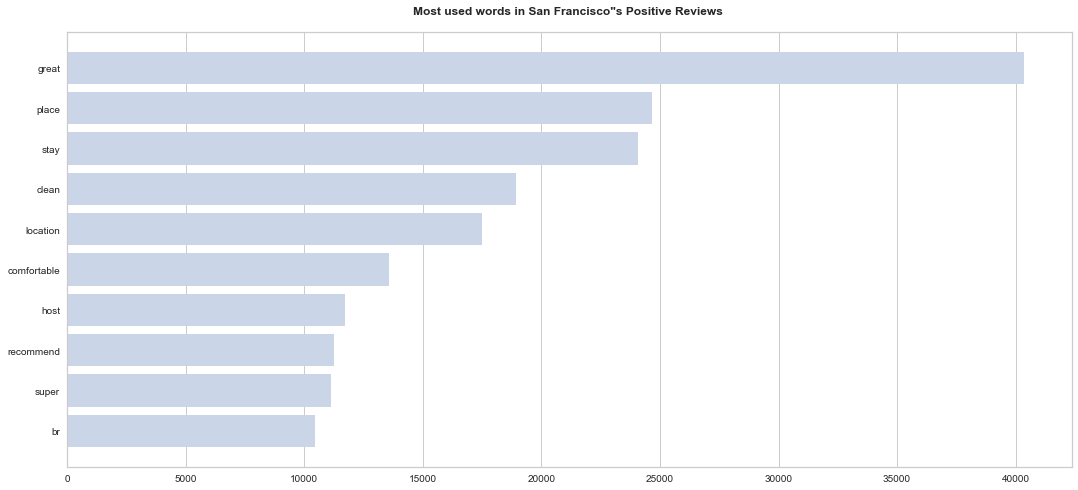

In [115]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('Most used words in San Francisco"s Positive Reviews \n', fontweight='bold')

##yellowbrick
vis = FreqDistVisualizer(features=features, n = 10)
vis.fit(docs)
vis.poof;

## Creating World Cloud words

In [116]:
def wordcloud_words(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(' San Francisco Positive Reviews\n', fontsize=18, fontweight='bold')
    plt.show()

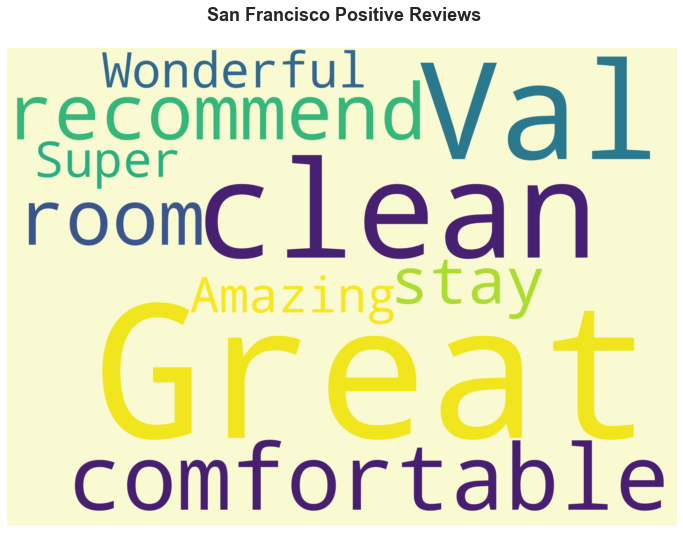

In [117]:
posWords = WordCloud(max_font_size=None, max_words = 10, background_color="lightgoldenrodyellow", 
                      width=3500, height=2500,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))

wordcloud_words(posWords)

## Simple Additional Cleaning

In [118]:
def clean(sents):
    for word in sents:
        word = re.sub('\s+', ' ', word)  
        word = re.sub("\'", "", word)  
        word = gensim.utils.simple_preprocess(str(word), deacc=True) 
        yield(word)  


# Apply cleaning

In [119]:
all_data = df.comments.values.tolist()
clean_sent = list(clean(all_data))
print(clean_sent[:1])

[['great', 'stay', 'clean', 'comfortable', 'safe', 'beautiful']]


In [120]:
print(clean_sent[:5])

[['great', 'stay', 'clean', 'comfortable', 'safe', 'beautiful'], ['amazing', 'super', 'clean', 'super', 'helpful', 'wonderful', 'experience', 'lovely', 'roof', 'top'], ['great', 'home', 'great', 'location', 'great', 'great', 'great'], ['easy', 'check', 'in', 'super', 'clean', 'great', 'location', 'fantastic', 'value'], ['sparkling', 'clean', 'perfect', 'location', 'very', 'comfortable', 'definitely', 'recommend']]


## Bigram & Trigram

In [121]:

bi_gram = gensim.models.Phrases(clean_sent, min_count=5, threshold=100) 

tri_gram = gensim.models.Phrases(bi_gram[clean_sent], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bi_gram)

trigram_mod = gensim.models.phrases.Phraser(tri_gram)

## Clean, Remove & Lemma

In [122]:

def cleaning(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])     
    
    clean_text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    
    return clean_text


## Apply final cleaning on prev cleaned list

In [123]:
doc_clean = cleaning(clean_sent)
doc_clean[:5]

[['great', 'stay', 'clean', 'comfortable', 'safe', 'beautiful'],
 ['amazing',
  'super',
  'clean',
  'super',
  'helpful',
  'wonderful',
  'experience',
  'lovely',
  'roof_top'],
 ['great', 'home', 'great', 'location', 'great', 'great', 'great'],
 ['easy',
  'check',
  'super',
  'clean',
  'great',
  'location',
  'fantastic',
  'value'],
 ['clean', 'perfect', 'location', 'comfortable', 'definitely', 'recommend']]

## Create Dictionary & Corpus

In [124]:
doc_dict = corpora.Dictionary(doc_clean)

corpus = [doc_dict.doc2bow(text) for text in doc_clean]


## Build The LDA model

In [125]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=8, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.000*"val" + 0.000*"outdated" + 0.000*"beverly" + 0.000*"caroline" + '
  '0.000*"assistant" + 0.000*"nico" + 0.000*"airnbnbs" + 0.000*"mikey" + '
  '0.000*"mai" + 0.000*"lil"'),
 (1,
  '0.052*"love" + 0.043*"bed" + 0.043*"enjoy" + 0.042*"comfortable" + '
  '0.038*"quiet" + 0.037*"view" + 0.030*"lot" + 0.025*"kitchen" + 0.023*"even" '
  '+ 0.021*"coffee"'),
 (2,
  '0.000*"val" + 0.000*"outdated" + 0.000*"beverly" + 0.000*"caroline" + '
  '0.000*"assistant" + 0.000*"nico" + 0.000*"airnbnbs" + 0.000*"mikey" + '
  '0.000*"mai" + 0.000*"lil"'),
 (3,
  '0.104*"room" + 0.096*"apartment" + 0.035*"responsive" + '
  '0.032*"communication" + 0.031*"safe" + 0.029*"give" + 0.028*"absolutely" + '
  '0.022*"downtown" + 0.019*"recommendation" + 0.018*"share"'),
 (4,
  '0.049*"recommend" + 0.037*"definitely" + 0.036*"well" + 0.034*"good" + '
  '0.030*"time" + 0.029*"br" + 0.028*"comfortable" + 0.027*"neighborhood" + '
  '0.026*"city" + 0.026*"restaurant"'),
 (5,
  '0.060*"stay" + 0.060*"great"

## List of words by topic

In [126]:
topics = lda_model.show_topics(formatted=False)

In [127]:
type(topics)

list

In [128]:
topics

[(0,
  [('val', 9.431555e-05),
   ('outdated', 9.423505e-05),
   ('beverly', 9.420191e-05),
   ('caroline', 9.419561e-05),
   ('assistant', 9.408742e-05),
   ('nico', 9.408125e-05),
   ('airnbnbs', 9.408125e-05),
   ('mikey', 9.403086e-05),
   ('mai', 9.401416e-05),
   ('lil', 9.397155e-05)]),
 (1,
  [('love', 0.05236591),
   ('bed', 0.04309325),
   ('enjoy', 0.042774353),
   ('comfortable', 0.042104494),
   ('quiet', 0.037521996),
   ('view', 0.036727197),
   ('lot', 0.03041954),
   ('kitchen', 0.02524706),
   ('even', 0.022880325),
   ('coffee', 0.020855565)]),
 (2,
  [('val', 9.431549e-05),
   ('outdated', 9.423504e-05),
   ('beverly', 9.420191e-05),
   ('caroline', 9.4195595e-05),
   ('assistant', 9.4087445e-05),
   ('nico', 9.408125e-05),
   ('airnbnbs', 9.408125e-05),
   ('mikey', 9.403086e-05),
   ('mai', 9.401416e-05),
   ('lil', 9.397165e-05)]),
 (3,
  [('room', 0.10366586),
   ('apartment', 0.09591125),
   ('responsive', 0.035284873),
   ('communication', 0.031925768),
   ('s

## Visualize the words By Topic

In [129]:
topics = lda_model.show_topics(formatted=False)

In [130]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [131]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [132]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
30,room,3,0.103666,7380
31,apartment,3,0.095911,7142
50,stay,5,0.060373,29483
51,great,5,0.060112,39961
10,love,1,0.052366,8008
40,recommend,4,0.048551,13027
52,place,5,0.046581,24128
11,bed,1,0.043093,5828
12,enjoy,1,0.042774,4926
13,comfortable,1,0.042104,13339


## Word Count as Weights by Topic Visualization

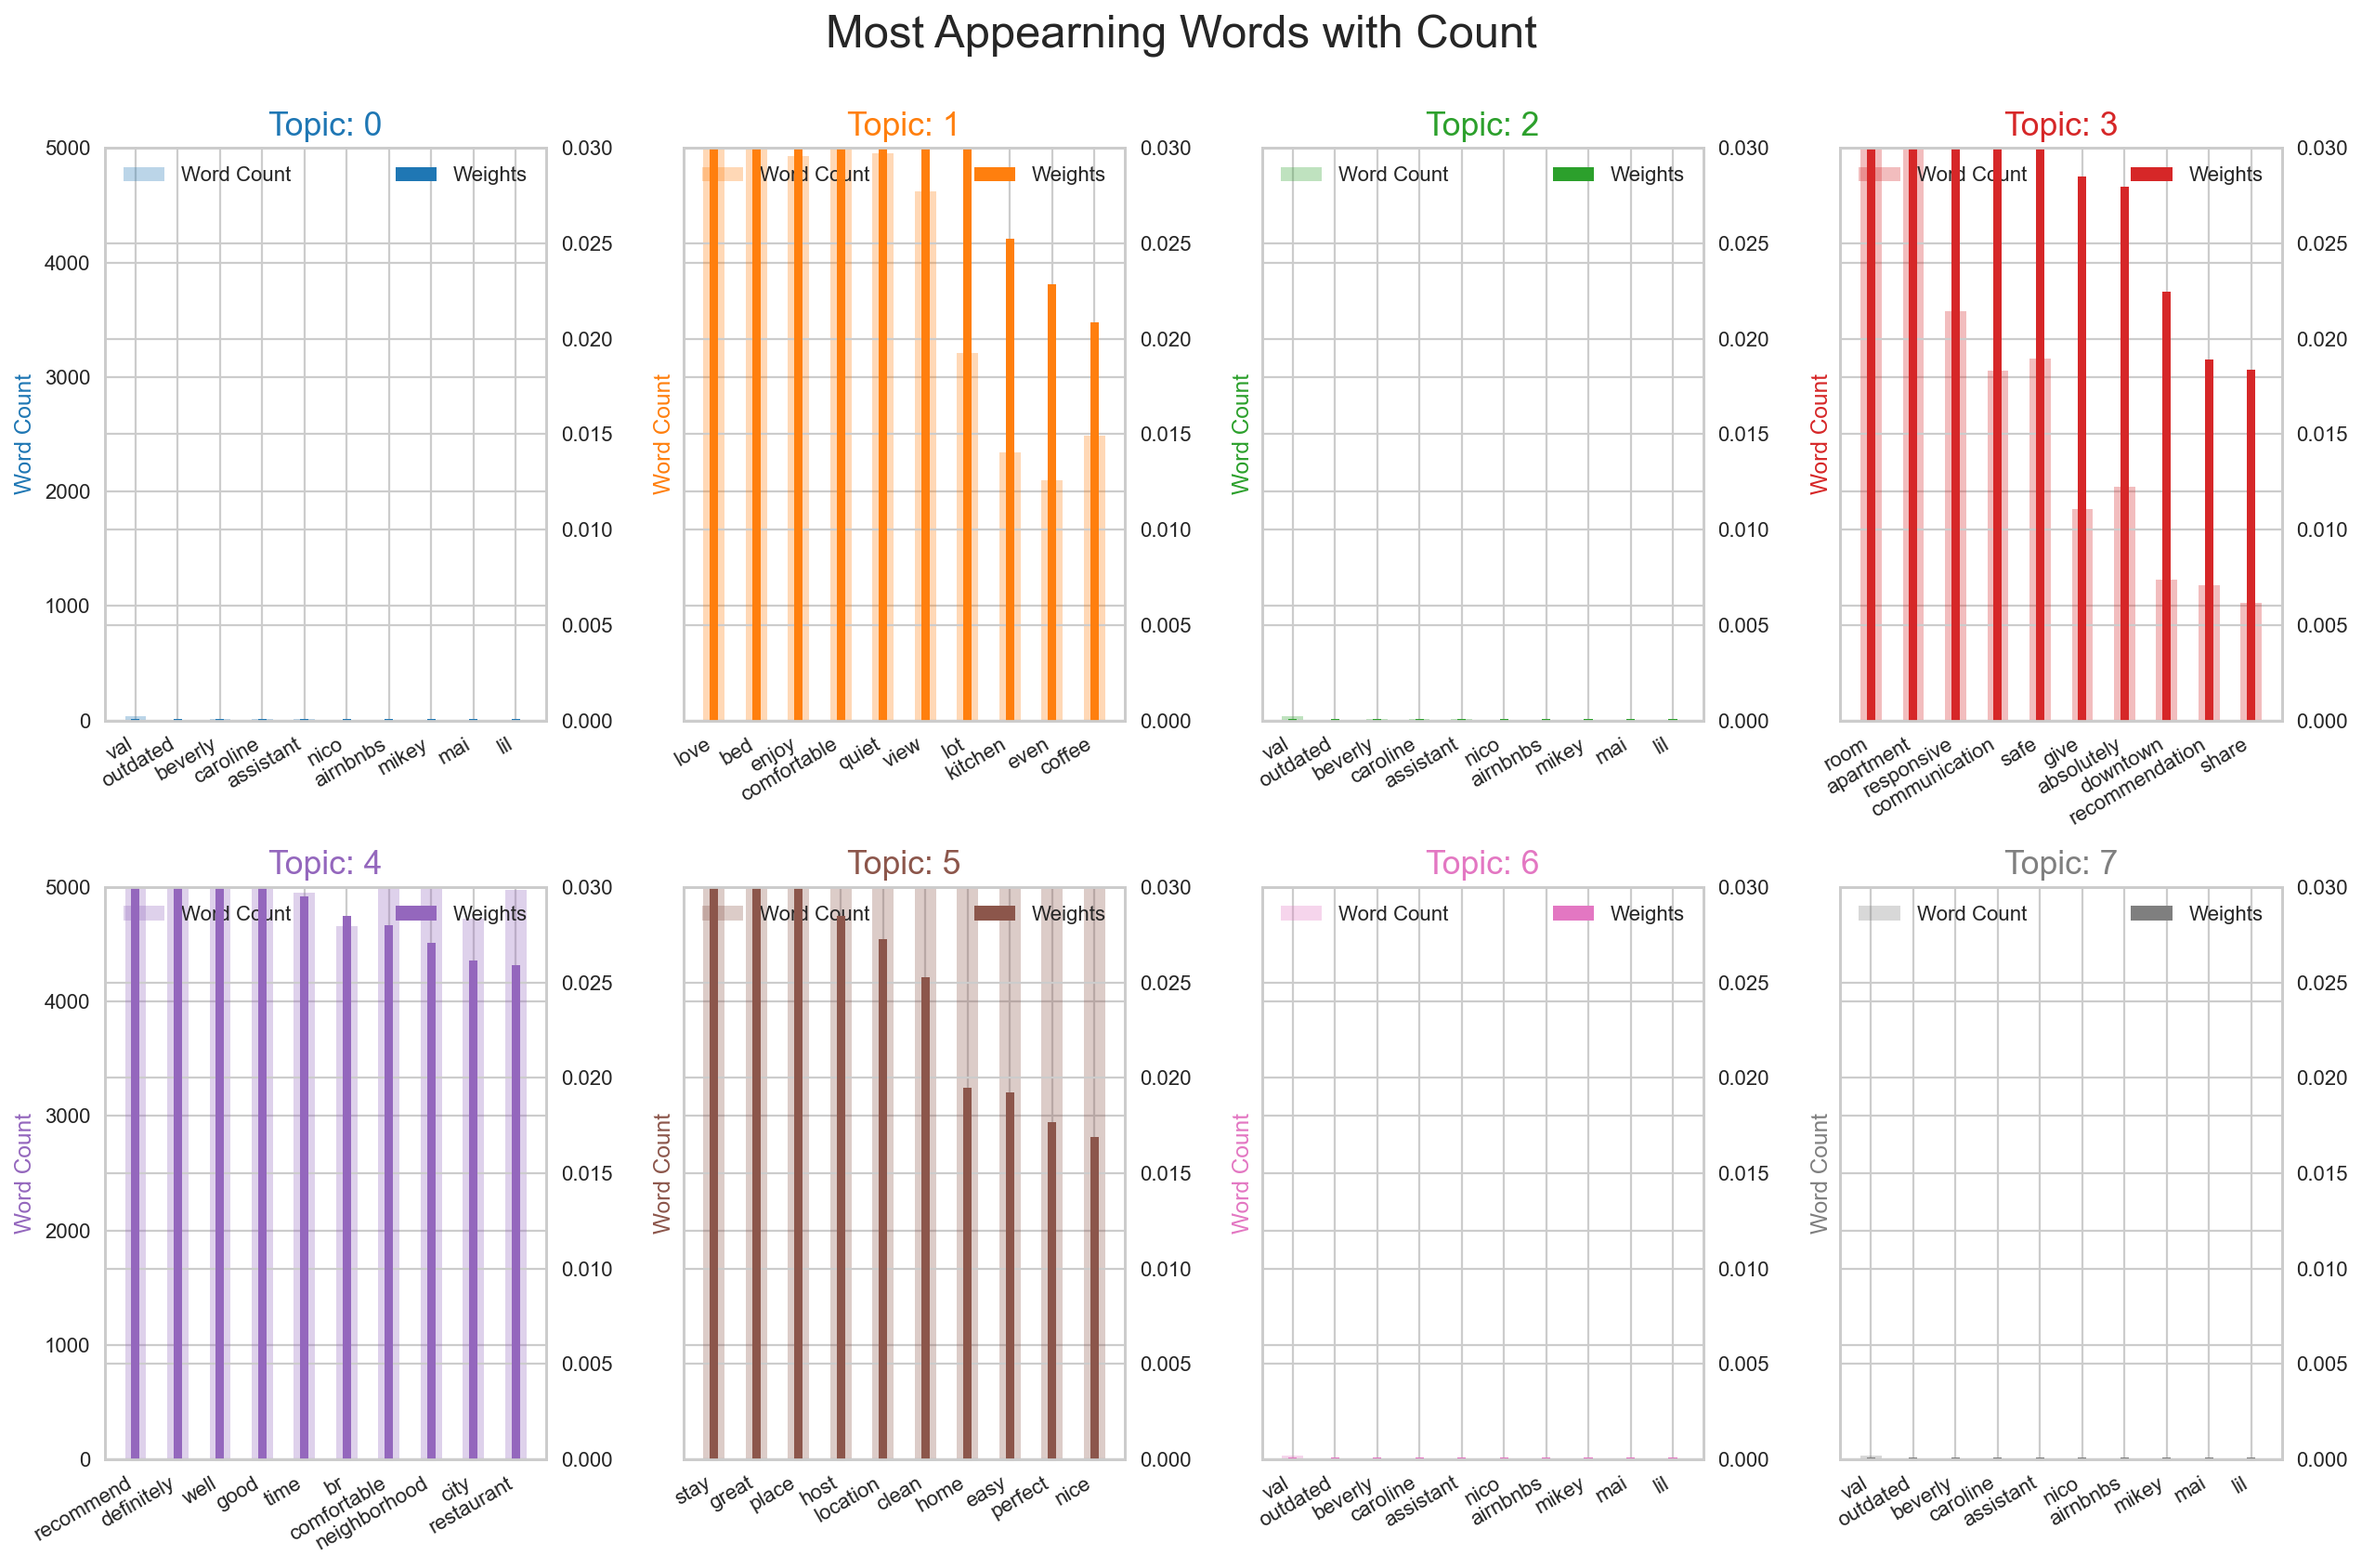

In [133]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [134]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


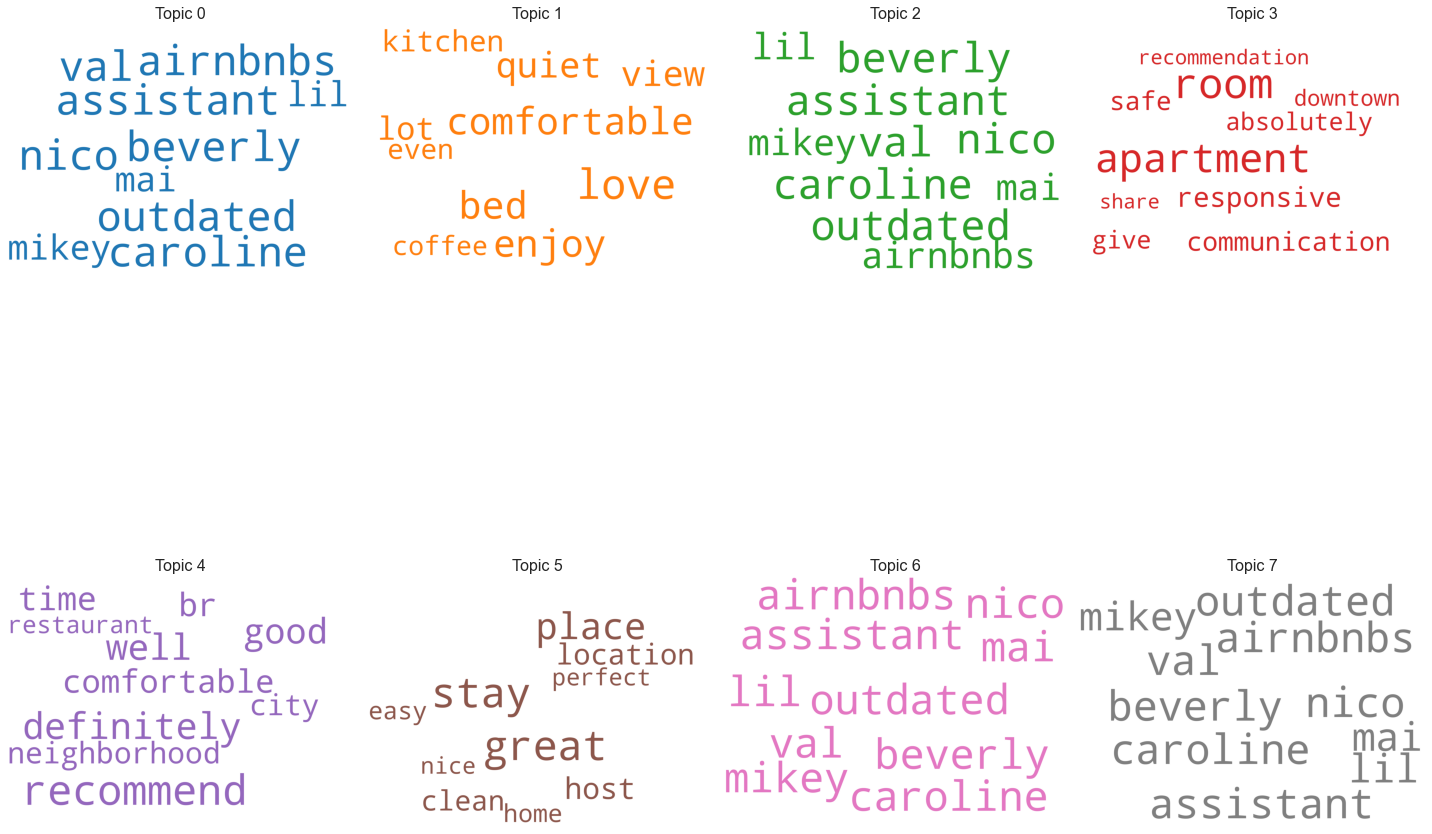

In [135]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 3 topics

In [136]:

nmf = NMF(n_components=3)

nmf.fit(docs)

NMF(n_components=3)

In [137]:
topic_matrix = nmf.transform(docs)

In [138]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.053476,0.000000,0.041914,NaN
1,0.056653,0.004074,0.000000,NaN
2,0.000000,0.000000,0.239389,NaN
3,0.034295,0.000000,0.059140,"Great stay! Clean, comfortable, safe, beautiful."
4,0.059198,0.000000,0.006314,NaN


In [139]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
00,0.000275,0.000701,0.001188
00m,0.000000,0.000000,0.000503
00pm,0.000000,0.002144,0.000267
10,0.234942,0.055993,0.051744
100,0.104046,0.008907,0.001498


## Read Samples from Topic 0 

In [140]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

nan

nan

Great apartment at great location. Pet friendly which was the deciding factor for us. Very nicely decorated with all the amenities and a few extra touches. Rachel was a great host and took care of any issues promptly. Would definitely recommend!!!

nan

Excellent location, easy check-in, beautiful house, gorgeous / spacious back garden, huge bedrooms with an extremely comfortable bed which felt great after a 13 hour flight! I would highly recommend this property to anyone looking to stay in San Francisco for a few days - we had superb few days 

nan

Josh was very accommodating and helpful during our stay.  Made us feel at home.  The apartment is clean, comfortable and in a wonderful location.  We had a great stay.

nan

nan

Peaceful perfection for exploring SF.<br/><br/>Clare is an awesome host with a beautiful space! Potrero Hill has amazing views, shops, and restaurants. We slept great -- super quiet! Very easy to walk to the Mission and Dogpatch for more transportation o

## Read Samples from Topic 1 


In [141]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Great location right in the heart of the mission. Very close to BART, with plenty of good food, entertainment and laundry options nearby. Cynthia’s apartment is clean, stylish, and modern. We had a perfect stay!

This is my second time staying and I love it! It is private and very clean. The heater works very well for a cold night. Great location, highly recommend!

Judy is such a nice and caring host! We stayed for 2 nights and she made sure we knew all the great local spots. I would highly recommend staying here, it's beautiful.

nan

Whei has such great energy, as does her home. Place is clean, inviting, peaceful, and has unique style. She was very, very welcoming and it was great to get to know her, as she took me to a great Ramen place where i tried octopus and we shared a beer. Highly recommend!



## Read Samples from Topic 2


In [142]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Perfect location! Walking distance to everything in The Mission. Lots of great bars, restaurants & shops. Great size room and a cute little courtyard. She was very responsive and accommodating.

Tim's place was great – definitely one of the best Airbnb's I've stayed in. Great location, clean, and well appointed. Definitely will be back!

a perfect place to stay within the city, the hosts are amazing and know alot about the city and surroundings. clean, comfortable and fun

nan

Nice location, easy to reach. Super clean room and super comfy bed. Thank you Fa for the snack and water provided. 100% recommend



# Top 10 Words from Each Topic

In [143]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [144]:
display_topics(nmf, features, 10)


Topic  0
place, stay, clean, comfortable, super, recommend, definitely, perfect, nice, beautiful

Topic  1
br, nice, really, home, apartment, house, good, amazing, host, beautiful

Topic  2
great, location, host, easy, apartment, restaurants, space, neighborhood, room, close


In [145]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
place,8.854218,0.000000,0.272810
stay,8.411195,0.117727,0.322752
clean,5.629099,0.294241,0.642008
comfortable,4.216727,0.261238,0.209535
super,3.451166,0.307329,0.110478
recommend,3.316478,0.293925,0.429347
definitely,3.053038,0.017392,0.221281
perfect,2.843440,0.291773,0.000000
nice,2.780516,0.678372,0.380136
beautiful,2.415768,0.405473,0.000000


In [146]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
br,0.000000,13.688429,0.000000
nice,2.780516,0.678372,0.380136
really,2.063567,0.673014,0.327098
home,2.267587,0.580632,0.011645
apartment,1.312857,0.563765,1.045675
house,1.065174,0.550957,0.401252
good,1.095861,0.477532,0.379300
amazing,2.144889,0.449818,0.000000
host,2.025660,0.449709,2.095798
beautiful,2.415768,0.405473,0.000000


In [147]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
great,0.000000,0.000000,19.741890
location,2.339179,0.028779,4.519090
host,2.025660,0.449709,2.095798
easy,2.414658,0.238954,1.089796
apartment,1.312857,0.563765,1.045675
restaurants,0.798251,0.232643,0.998170
space,1.186757,0.216839,0.974334
neighborhood,1.328348,0.190450,0.823806
room,1.569875,0.368472,0.706971
close,0.988682,0.217313,0.698898


In [148]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [149]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

nan

nan

Great apartment at great location. Pet friendly which was the deciding factor for us. Very nicely decorated with all the amenities and a few extra touches. Rachel was a great host and took care of any issues promptly. Would definitely recommend!!!

nan

Excellent location, easy check-in, beautiful house, gorgeous / spacious back garden, huge bedrooms with an extremely comfortable bed which felt great after a 13 hour flight! I would highly recommend this property to anyone looking to stay in San Francisco for a few days - we had superb few days 



In [150]:
top_words(word_topic_matrix_df, 'topic_0', 10)

place          8.854218
stay           8.411195
clean          5.629099
comfortable    4.216727
super          3.451166
recommend      3.316478
definitely     3.053038
perfect        2.843440
nice           2.780516
beautiful      2.415768
Name: topic_0, dtype: float64

In [151]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Great location right in the heart of the mission. Very close to BART, with plenty of good food, entertainment and laundry options nearby. Cynthia’s apartment is clean, stylish, and modern. We had a perfect stay!

This is my second time staying and I love it! It is private and very clean. The heater works very well for a cold night. Great location, highly recommend!

Judy is such a nice and caring host! We stayed for 2 nights and she made sure we knew all the great local spots. I would highly recommend staying here, it's beautiful.

nan

Whei has such great energy, as does her home. Place is clean, inviting, peaceful, and has unique style. She was very, very welcoming and it was great to get to know her, as she took me to a great Ramen place where i tried octopus and we shared a beer. Highly recommend!



In [152]:
top_words(word_topic_matrix_df, 'topic_1', 10)

br           13.688429
nice          0.678372
really        0.673014
home          0.580632
apartment     0.563765
house         0.550957
good          0.477532
amazing       0.449818
host          0.449709
beautiful     0.405473
Name: topic_1, dtype: float64

In [153]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

Perfect location! Walking distance to everything in The Mission. Lots of great bars, restaurants & shops. Great size room and a cute little courtyard. She was very responsive and accommodating.

Tim's place was great – definitely one of the best Airbnb's I've stayed in. Great location, clean, and well appointed. Definitely will be back!

a perfect place to stay within the city, the hosts are amazing and know alot about the city and surroundings. clean, comfortable and fun

nan

Nice location, easy to reach. Super clean room and super comfy bed. Thank you Fa for the snack and water provided. 100% recommend



In [154]:
top_words(word_topic_matrix_df, 'topic_2', 10)

great           19.741890
location         4.519090
host             2.095798
easy             1.089796
apartment        1.045675
restaurants      0.998170
space            0.974334
neighborhood     0.823806
room             0.706971
close            0.698898
Name: topic_2, dtype: float64

In [155]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [156]:
tl_dict = t1.to_dict()

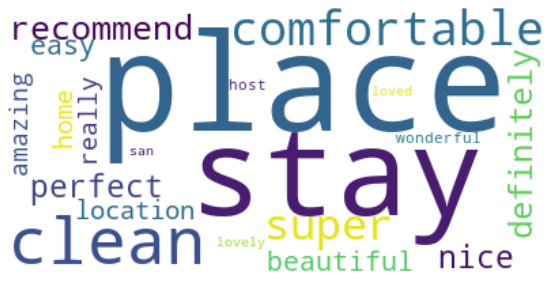

In [157]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('sf_locationPos')
plt.show()


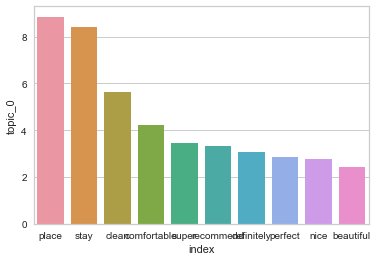

In [158]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [159]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

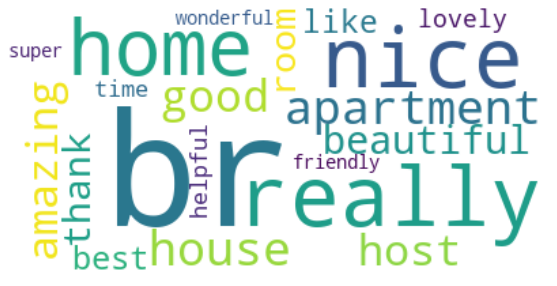

In [160]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


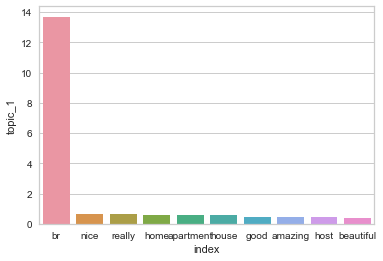

In [161]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

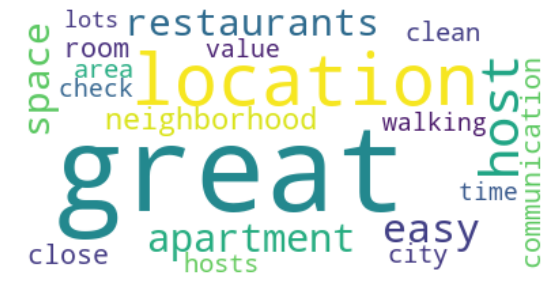

In [162]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

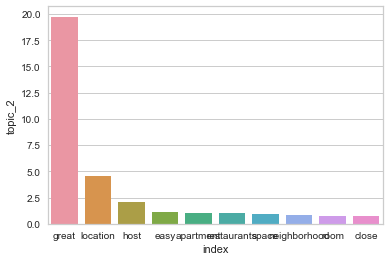

In [163]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);

## LDA model With 5 Topics

In [164]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=5, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.045*"well" + 0.044*"make" + 0.044*"really" + 0.040*"beautiful" + '
  '0.039*"feel" + 0.031*"enjoy" + 0.028*"lovely" + 0.027*"helpful" + '
  '0.022*"experience" + 0.017*"even"'),
 (1,
  '0.049*"love" + 0.044*"walk" + 0.042*"restaurant" + 0.041*"amazing" + '
  '0.038*"close" + 0.035*"quiet" + 0.028*"lot" + 0.020*"coffee" + '
  '0.018*"distance" + 0.018*"many"'),
 (2,
  '0.060*"br" + 0.053*"neighborhood" + 0.051*"space" + 0.050*"recommend" + '
  '0.042*"area" + 0.042*"highly" + 0.041*"view" + 0.030*"parking" + '
  '0.028*"kitchen" + 0.027*"street"'),
 (3,
  '0.093*"great" + 0.072*"place" + 0.066*"stay" + 0.036*"location" + '
  '0.031*"host" + 0.030*"easy" + 0.029*"clean" + 0.025*"good" + '
  '0.025*"apartment" + 0.022*"nice"'),
 (4,
  '0.050*"home" + 0.045*"perfect" + 0.045*"stay" + 0.044*"definitely" + '
  '0.031*"comfortable" + 0.030*"bed" + 0.028*"recommend" + 0.026*"get" + '
  '0.020*"sf" + 0.019*"back"')]


## List of words by topic

In [165]:
topics = lda_model.show_topics(formatted=False)

In [166]:
type(topics)

list

In [167]:
topics

[(0,
  [('well', 0.045312364),
   ('make', 0.044283956),
   ('really', 0.044259228),
   ('beautiful', 0.03993463),
   ('feel', 0.038538292),
   ('enjoy', 0.031079777),
   ('lovely', 0.027823443),
   ('helpful', 0.026630176),
   ('experience', 0.021689799),
   ('even', 0.016624961)]),
 (1,
  [('love', 0.048981935),
   ('walk', 0.043895274),
   ('restaurant', 0.04227931),
   ('amazing', 0.041130986),
   ('close', 0.038379923),
   ('quiet', 0.035097297),
   ('lot', 0.02845399),
   ('coffee', 0.019507967),
   ('distance', 0.018475808),
   ('many', 0.018187653)]),
 (2,
  [('br', 0.059744053),
   ('neighborhood', 0.052923344),
   ('space', 0.051461887),
   ('recommend', 0.049617205),
   ('area', 0.042461567),
   ('highly', 0.04193188),
   ('view', 0.04116534),
   ('parking', 0.030088583),
   ('kitchen', 0.028297778),
   ('street', 0.02670694)]),
 (3,
  [('great', 0.09285018),
   ('place', 0.071950205),
   ('stay', 0.066273205),
   ('location', 0.03585972),
   ('host', 0.03145428),
   ('easy'

## Visualize the words By Topic

In [168]:
topics = lda_model.show_topics(formatted=False)

In [169]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [170]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [171]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
30,great,3,0.092850,39961
31,place,3,0.071950,24128
32,stay,3,0.066273,29483
20,br,2,0.059744,4655
21,neighborhood,2,0.052923,6463
22,space,2,0.051462,6535
40,home,4,0.049778,7599
23,recommend,2,0.049617,13027
10,love,1,0.048982,8008
0,well,0,0.045312,7156


## Word Count as Weights by Topic Visualization

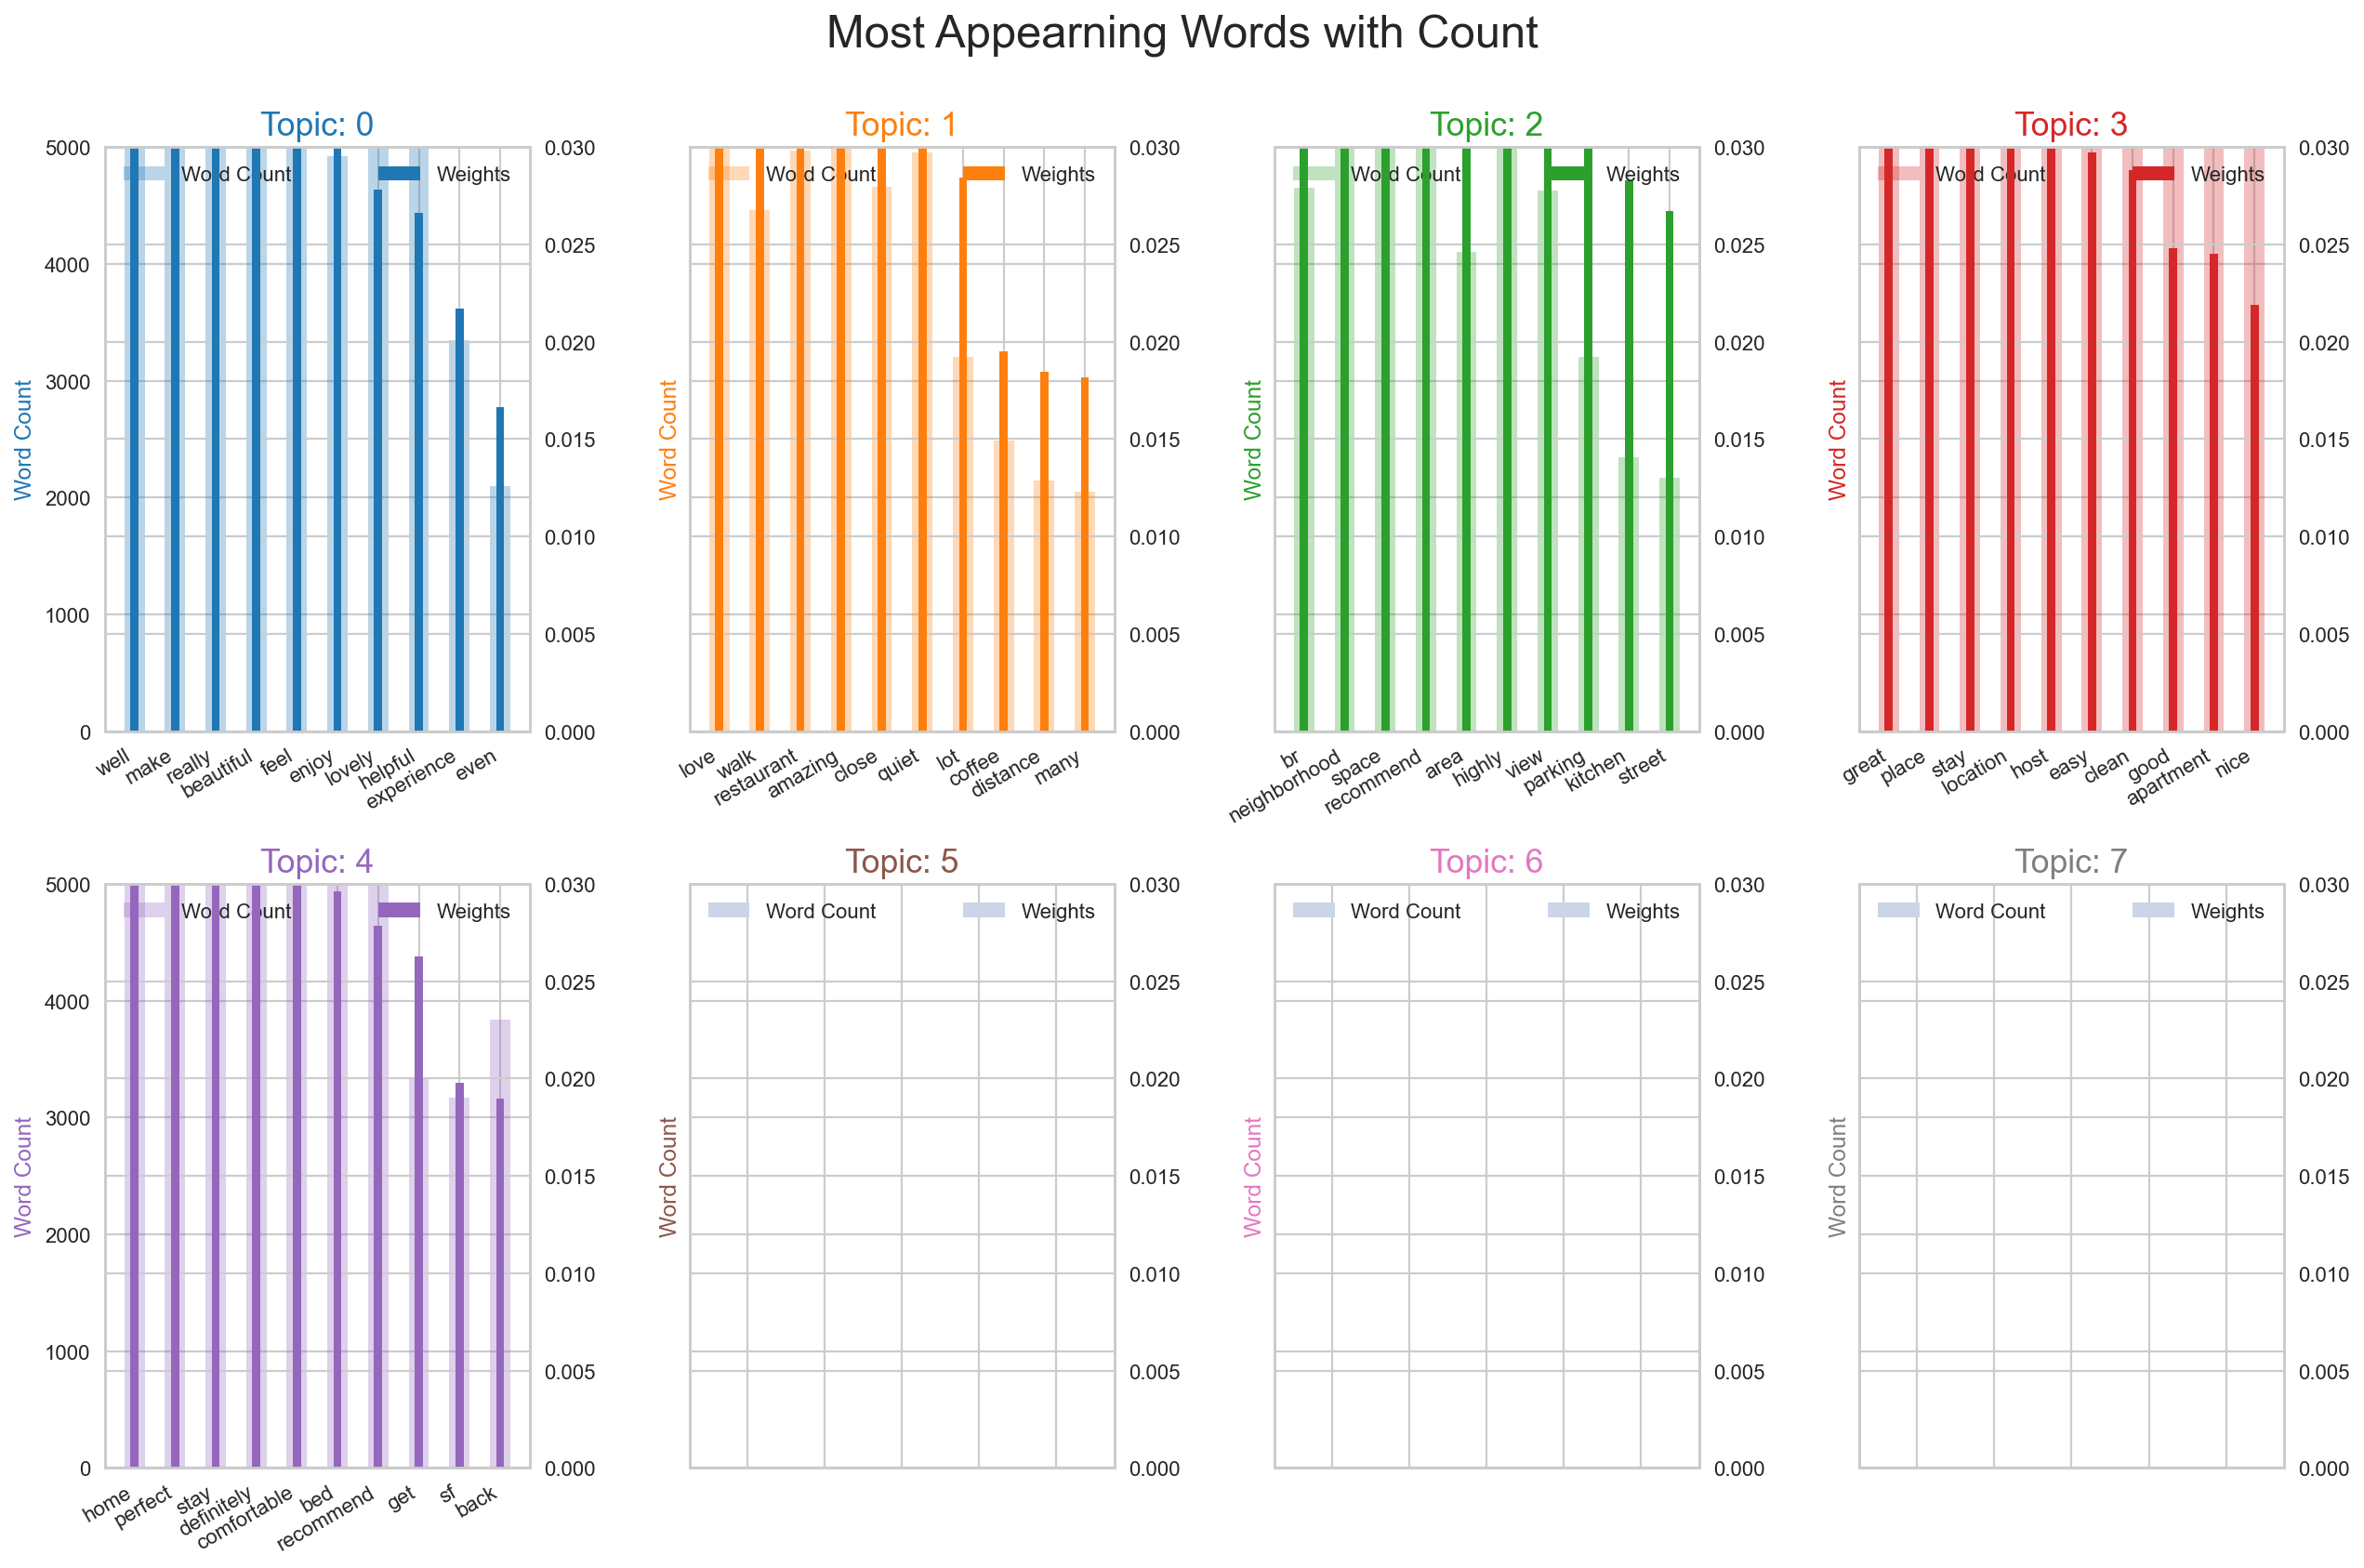

In [172]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [173]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


IndexError: list index out of range

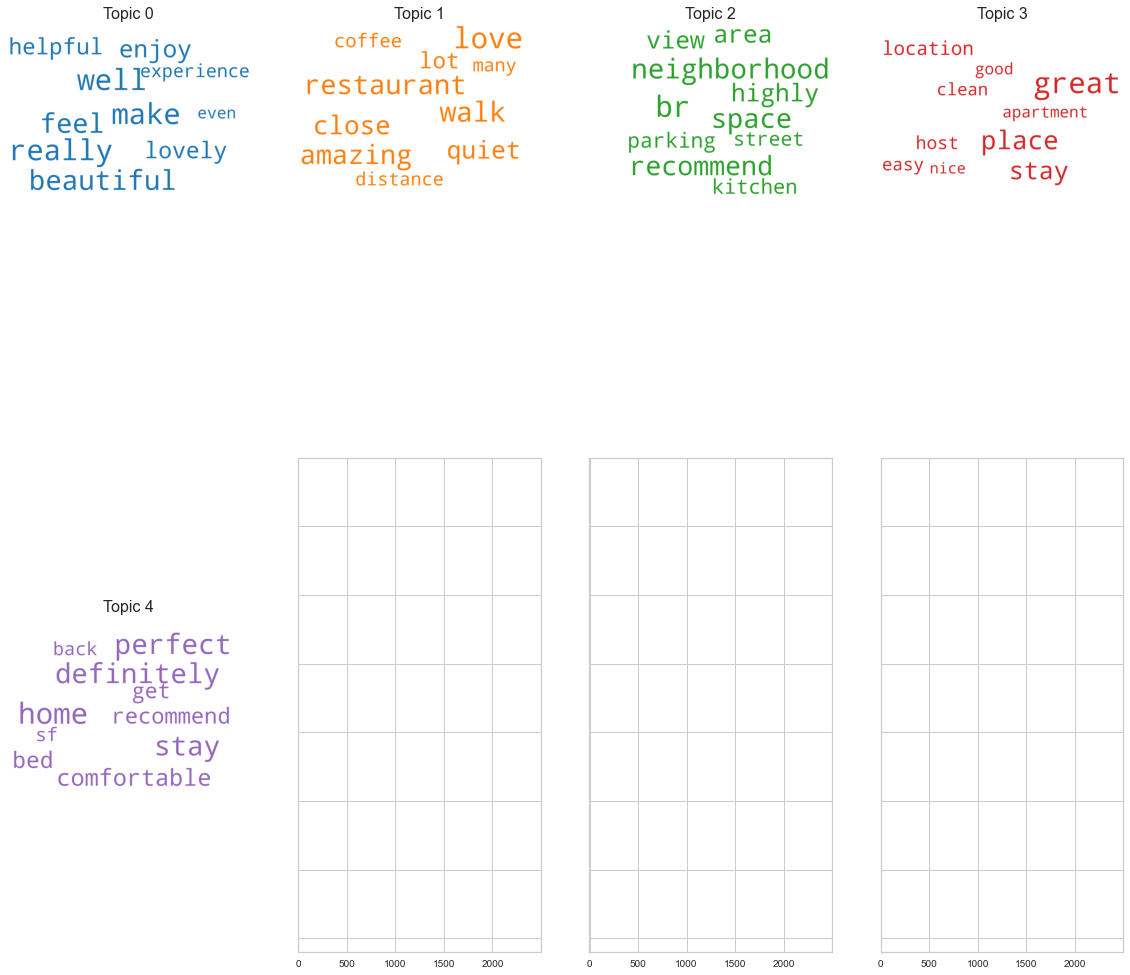

In [174]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 5 topics

In [175]:

nmf5 = NMF(n_components=5)

nmf5.fit(docs)

NMF(n_components=5)

In [176]:
topic_matrix = nmf5.transform(docs)

In [177]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,comments
0,0.041181,0.0,0.044942,0.000000,0.066173,NaN
1,0.073215,0.0,0.000000,0.013760,0.000635,NaN
2,0.000000,0.0,0.261072,0.000000,0.000000,NaN
3,0.060566,0.0,0.058163,0.002070,0.000000,"Great stay! Clean, comfortable, safe, beautiful."
4,0.077715,0.0,0.001615,0.009046,0.005990,NaN


In [178]:
word_topic_matrix_df = pd.DataFrame(nmf5.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
00,0.000143,0.000710,0.001062,0.000352,0.000000
00m,0.000379,0.000000,0.000264,0.000000,0.000000
00pm,0.000000,0.002065,0.000194,0.000196,0.000000
10,0.214256,0.043557,0.031841,0.113389,0.039460
100,0.078306,0.004431,0.000000,0.049004,0.029774


## Read Samples from Topic 0 

In [179]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

This place was beautiful and easy to find transportation to the city and the near by mall. The home was beautiful and peaceful and the sights near by were amazing

Great location -- quiet and secluded but close to businesses in Potrero Hill and easy to get downtown. Very clean, and David is easy to communicate with and very clear. Check in was no problem.

nan

nan

Ben's apartment was beautiful, bright, quite, very comfortable and stylish. The location is fantastic! <br/>He is the most responsive, helpful and welcoming host we have ever had with Airbnb. <br/>He deserves a 6 star rating!

Springer was fantastic during the whole stay.  The apartment is beautiful and my daughter and I enjoyed ourselves immensely.  Great location, great walks and close to everything.  

A fantastic location, sparkling accommodations, and a communicative host makes for an excellent place to stay. We loved our too short getaway and would definitely book a return visit. Peter is a wonderful host.

Great airb

## Read Samples from Topic 1 


In [180]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Great location right in the heart of the mission. Very close to BART, with plenty of good food, entertainment and laundry options nearby. Cynthia’s apartment is clean, stylish, and modern. We had a perfect stay!

This is my second time staying and I love it! It is private and very clean. The heater works very well for a cold night. Great location, highly recommend!

Judy is such a nice and caring host! We stayed for 2 nights and she made sure we knew all the great local spots. I would highly recommend staying here, it's beautiful.

Whei has such great energy, as does her home. Place is clean, inviting, peaceful, and has unique style. She was very, very welcoming and it was great to get to know her, as she took me to a great Ramen place where i tried octopus and we shared a beer. Highly recommend!

nan



## Read Samples from Topic 2


In [181]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Perfect location! Walking distance to everything in The Mission. Lots of great bars, restaurants & shops. Great size room and a cute little courtyard. She was very responsive and accommodating.

Tim's place was great – definitely one of the best Airbnb's I've stayed in. Great location, clean, and well appointed. Definitely will be back!

a perfect place to stay within the city, the hosts are amazing and know alot about the city and surroundings. clean, comfortable and fun

nan

Nice location, easy to reach. Super clean room and super comfy bed. Thank you Fa for the snack and water provided. 100% recommend



# Top 10 Words from Each Topic

In [182]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [183]:
display_topics(nmf, features, 10)


Topic  0
place, stay, clean, comfortable, super, recommend, definitely, perfect, nice, beautiful

Topic  1
br, nice, really, home, apartment, house, good, amazing, host, beautiful

Topic  2
great, location, host, easy, apartment, restaurants, space, neighborhood, room, close


In [184]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
clean,6.917592,0.000000,0.063920,2.031100,0.000000
comfortable,5.388872,0.000000,0.000000,0.367816,0.922433
location,3.926391,0.000000,3.870416,0.000000,0.000000
super,3.895513,0.081970,0.000000,1.450637,0.000000
nice,3.549035,0.445731,0.000092,1.064180,0.000000
easy,3.532323,0.057816,0.713212,0.437186,0.027126
home,3.312320,0.309005,0.000000,0.000000,0.391965
recommend,3.119812,0.131799,0.111196,2.060582,0.000000
beautiful,2.922145,0.204017,0.000000,0.250190,0.573463
room,2.787376,0.180766,0.353532,0.000000,0.079357


In [185]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
br,0.000000,13.507480,0.000000,0.000000,0.000000
really,2.081482,0.543376,0.140447,0.632277,0.577926
nice,3.549035,0.445731,0.000092,1.064180,0.000000
house,1.867007,0.405763,0.182371,0.000000,0.077495
good,1.585984,0.374406,0.200887,0.262205,0.000000
amazing,1.526296,0.357661,0.000000,1.181402,0.473924
apartment,2.418317,0.344117,0.522090,0.000000,0.383644
thank,0.758589,0.326813,0.018449,0.127343,0.515851
home,3.312320,0.309005,0.000000,0.000000,0.391965
best,0.812118,0.308126,0.000000,0.394815,0.103556


In [186]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
great,0.000000,0.000000,18.528374,0.000000,0.000000
location,3.926391,0.000000,3.870416,0.000000,0.000000
host,2.678853,0.293237,1.756497,0.487908,0.119362
restaurants,1.323296,0.154886,0.828349,0.020199,0.001516
easy,3.532323,0.057816,0.713212,0.437186,0.027126
neighborhood,1.815639,0.083525,0.637450,0.262897,0.082001
space,2.217970,0.069280,0.627000,0.000000,0.046122
communication,0.448601,0.021706,0.596558,0.118188,0.145004
close,1.243332,0.148389,0.556466,0.330493,0.013973
apartment,2.418317,0.344117,0.522090,0.000000,0.383644


In [187]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [188]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

This place was beautiful and easy to find transportation to the city and the near by mall. The home was beautiful and peaceful and the sights near by were amazing

Great location -- quiet and secluded but close to businesses in Potrero Hill and easy to get downtown. Very clean, and David is easy to communicate with and very clear. Check in was no problem.

nan

nan

Ben's apartment was beautiful, bright, quite, very comfortable and stylish. The location is fantastic! <br/>He is the most responsive, helpful and welcoming host we have ever had with Airbnb. <br/>He deserves a 6 star rating!



In [189]:
top_words(word_topic_matrix_df, 'topic_0', 10)

clean          6.917592
comfortable    5.388872
location       3.926391
super          3.895513
nice           3.549035
easy           3.532323
home           3.312320
recommend      3.119812
beautiful      2.922145
room           2.787376
Name: topic_0, dtype: float64

In [190]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Great location right in the heart of the mission. Very close to BART, with plenty of good food, entertainment and laundry options nearby. Cynthia’s apartment is clean, stylish, and modern. We had a perfect stay!

This is my second time staying and I love it! It is private and very clean. The heater works very well for a cold night. Great location, highly recommend!

Judy is such a nice and caring host! We stayed for 2 nights and she made sure we knew all the great local spots. I would highly recommend staying here, it's beautiful.

Whei has such great energy, as does her home. Place is clean, inviting, peaceful, and has unique style. She was very, very welcoming and it was great to get to know her, as she took me to a great Ramen place where i tried octopus and we shared a beer. Highly recommend!

nan



In [191]:
top_words(word_topic_matrix_df, 'topic_1', 10)

br           13.507480
really        0.543376
nice          0.445731
house         0.405763
good          0.374406
amazing       0.357661
apartment     0.344117
thank         0.326813
home          0.309005
best          0.308126
Name: topic_1, dtype: float64

In [192]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

Perfect location! Walking distance to everything in The Mission. Lots of great bars, restaurants & shops. Great size room and a cute little courtyard. She was very responsive and accommodating.

Tim's place was great – definitely one of the best Airbnb's I've stayed in. Great location, clean, and well appointed. Definitely will be back!

a perfect place to stay within the city, the hosts are amazing and know alot about the city and surroundings. clean, comfortable and fun

nan

Nice location, easy to reach. Super clean room and super comfy bed. Thank you Fa for the snack and water provided. 100% recommend



In [193]:
top_words(word_topic_matrix_df, 'topic_2', 10)

great            18.528374
location          3.870416
host              1.756497
restaurants       0.828349
easy              0.713212
neighborhood      0.637450
space             0.627000
communication     0.596558
close             0.556466
apartment         0.522090
Name: topic_2, dtype: float64

In [194]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [195]:
tl_dict = t1.to_dict()

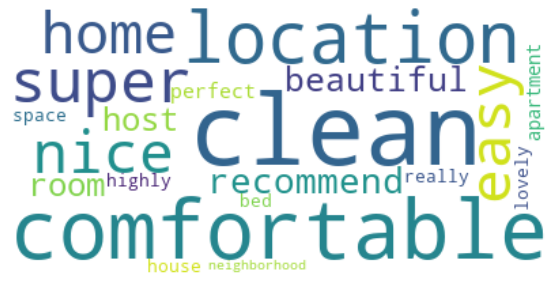

In [196]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


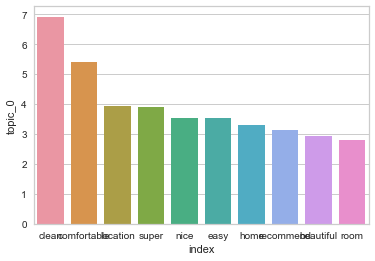

In [197]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [198]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

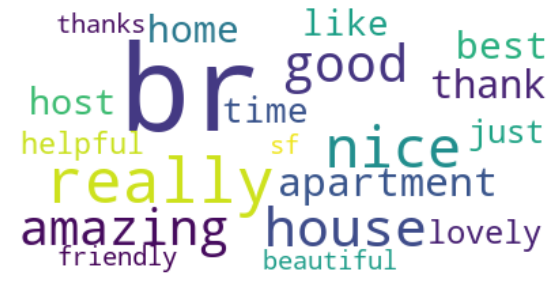

In [199]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('sf_Poshost1')
plt.show()


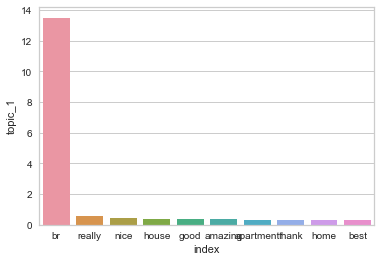

In [200]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

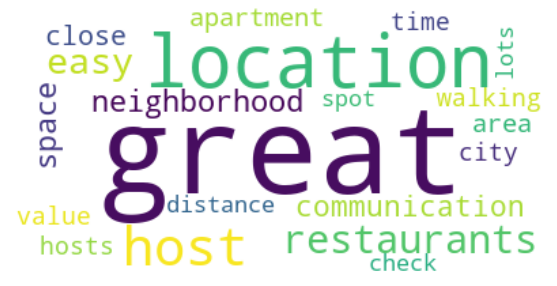

In [201]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

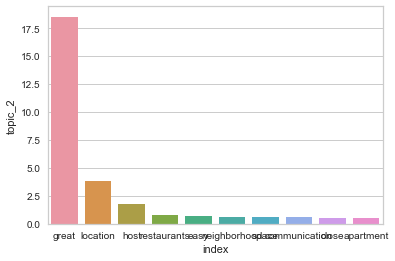

In [202]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);